# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Basic Setup

In [1]:
# Make sure that we use SageMaker 1.x
!pip install sagemaker==1.72.0

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Don't truncate data frame rows
pd.set_option("display.max_rows", None)
pd.set_option('display.max_columns', 100)

# Data Exploration

## Helper functions

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

color_blue = '#3251a8'

def show_distribution(df, col_name, title='', plot_type='bar', bins=None, color=color_blue, figsize=(14,4), show_percentages=False, xlim=None):
    #group = [col_name]
    counts = df.groupby(col_name).size().reset_index(name="Counts")
    #display(counts)

    plt.figure(figsize=figsize)
    plt.title(title if title else col_name, fontsize=12)
    
    if xlim:
        padding = 20
        plt.xlim(xlim[0]-padding, xlim[1]+padding)
    
    if plot_type == 'hist':
        plt.hist(df[col_name].dropna(axis=0), bins=bins)
        
    elif plot_type == 'bar':
        plt.bar(counts[col_name], counts['Counts'], color = color)
        
        # Annotate with percentages
        if show_percentages:
            ax = plt.gca()
            for p in ax.patches:
                width = p.get_width()
                height = p.get_height()
                x, y = p.get_xy()
                fraction = height / counts["Counts"].sum()
                percentage = int(round(fraction * 100))
                ax.annotate(f'{percentage}%', (x + width/2, y + height*1.03), ha='center', fontsize=10)
        
    elif plot_type == 'plot':
        plt.plot(counts[col_name], counts['Counts'], color = color)
        
    
    

In [4]:
def na_counts_for_col(df, col_name):
    return df[col_name].isna().sum()

## Portfolio (Offers)

In [5]:
display(portfolio.head(100))

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


#### Number of offers:

In [6]:
print(portfolio.shape[0])

10


#### Missing values:

In [7]:
portfolio.isna().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

# Profile (Customers)

### Preprocess missing values

In [8]:
# Replace obscure encoding (118) of "missing" value in age column with actual NaN
# Age column will be converted to float, but that's ok
profile['age'] = profile['age'].replace({118: np.nan})

### Data Samples

In [9]:
profile.head(30)

,gender,age,id,became_member_on,income
0,None,NaN,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,NaN,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,NaN,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
5,M,68.0,e2127556f4f64592b11af22de27a7932,20180426,70000.0
6,None,NaN,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,NaN,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
8,M,65.0,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
9,None,NaN,8974fc5686fe429db53ddde067b88302,20161122,NaN


#### Number of customers:

In [10]:
print(profile.shape[0])

17000


#### Missing values:

In [11]:
profile.isna().sum()

gender              2175
age                 2175
id                     0
became_member_on       0
income              2175
dtype: int64

#### Confirm intuition that entries either have all information filled in or all three values for age/gender/income are missing:

In [12]:
blank_profiles = profile.query('age.isnull() & gender.isnull() & income.isnull()', engine='python')
filled_profiles = profile.query('~(age.isnull() & gender.isnull() & income.isnull())', engine='python')
blank_profiles_n = blank_profiles.shape[0]
filled_profiles_n = filled_profiles.shape[0]
print(blank_profiles_n)

assert(profile.isna().sum()['gender'] == blank_profiles_n)
assert(profile.isna().sum()['age'] == blank_profiles_n)
assert(profile.isna().sum()['income'] == blank_profiles_n)

2175


#### What proportion of the customers would we lose if we dropped the blank ones?

In [13]:
print("%.2f" % (blank_profiles_n / profile.shape[0]))

0.13


#### Distribution of Data:
(note that rows with missing values are ignored, including in percentage calculations)

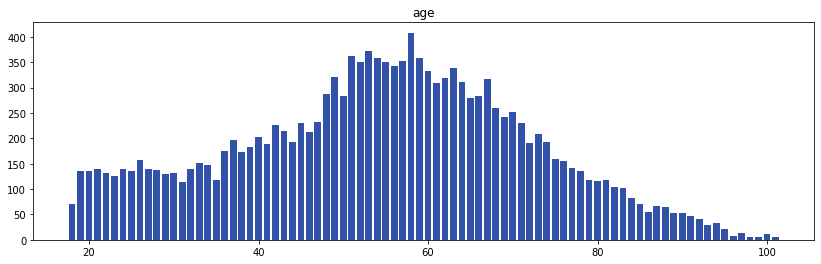

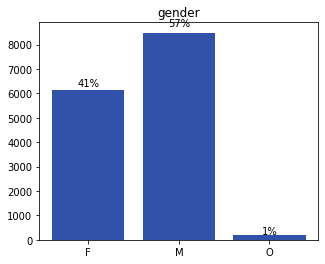

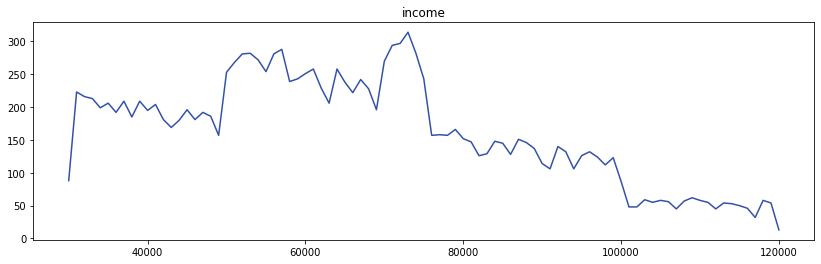

In [14]:
show_distribution(profile, 'age', plot_type='bar')
show_distribution(profile, 'gender', plot_type='bar', figsize=(5,4), show_percentages=True)
show_distribution(profile, 'income', plot_type='plot')

In [15]:
#clean_profile = profile.dropna(axis=0)
#display(clean_profile.head(20))
#print(clean_profile.shape[0])

# TODO next:
# Clean profile data frame and give explanation why it's ok to just drop all rows with NA values. The good thing is that it seems (check this!) that all rows are either "complete profiles" or "anonymous profiles" where age, income and gender are ALL not present. 
# Write function to check for NA rows and for checking how many "semi-complete" profiles there are

# Transcript (Events)

In [16]:
display(transcript.head(25))
display(transcript.tail(25))

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
6,c4863c7985cf408faee930f111475da3,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
9,31dda685af34476cad5bc968bdb01c53,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


,person,event,value,time
306509,8431c16f8e1d440880db371a68f82dd0,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714
306510,ba620885e51c4b0ea64a4f61daad494f,transaction,{'amount': 14.31},714
306511,a1a8f40407c444cc848468275308958a,transaction,{'amount': 2.37},714
306512,8d80970192fa496f99d6b45c470a4b60,transaction,{'amount': 6.92},714
306513,bde275066f3c4fa0bff3093e3b866a2c,transaction,{'amount': 12.73},714
306514,f1e4fd36e5a0446f83861308bddf6945,transaction,{'amount': 8.2},714
306515,0b64be3b241c4407a5c9a71781173829,transaction,{'amount': 2.6},714
306516,86d03d35d7e0434b935e7743e83be3a0,transaction,{'amount': 9.2},714
306517,3408fd05c781401f8442fb6dbaaea9c7,transaction,{'amount': 11.7},714
306518,1593d617fac246ef8e50dbb0ffd77f5f,transaction,{'amount': 40.67},714


#### Total number of events:

In [17]:
print(transcript.shape[0])

306534


#### All values that occur in the event column:

In [18]:
print(transcript['event'].unique())

['offer received' 'offer viewed' 'transaction' 'offer completed']


#### Unique people occuring in the event log:

In [19]:
print(transcript['person'].nunique())

17000


 *Observation: All people occur in the event log.*

#### All values that occur in the time column:

In [20]:
print(transcript['time'].unique())
print('\nNumber of time values: ', transcript['time'].nunique())

[  0   6  12  18  24  30  36  42  48  54  60  66  72  78  84  90  96 102
 108 114 120 126 132 138 144 150 156 162 168 174 180 186 192 198 204 210
 216 222 228 234 240 246 252 258 264 270 276 282 288 294 300 306 312 318
 324 330 336 342 348 354 360 366 372 378 384 390 396 402 408 414 420 426
 432 438 444 450 456 462 468 474 480 486 492 498 504 510 516 522 528 534
 540 546 552 558 564 570 576 582 588 594 600 606 612 618 624 630 636 642
 648 654 660 666 672 678 684 690 696 702 708 714]

Number of time values:  120


#### Missing values:

In [21]:
transcript.isna().sum()

person    0
event     0
value     0
time      0
dtype: int64

#### Distribution of Data:
(note that rows with missing values are ignored, including in percentage calculations)

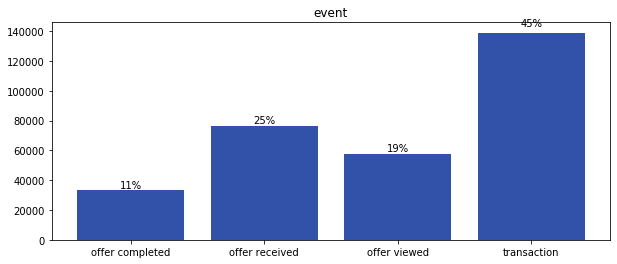

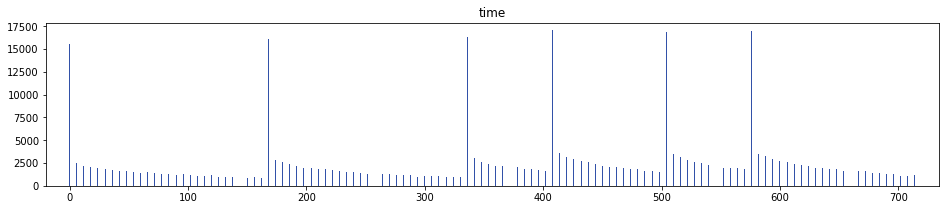

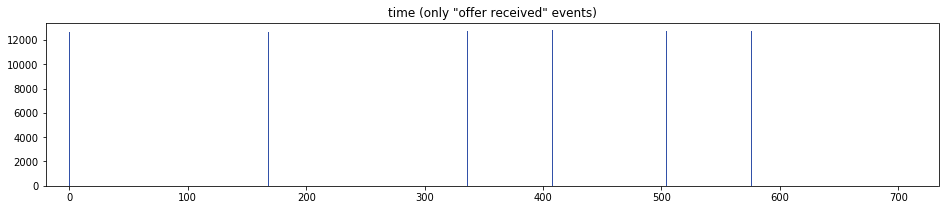

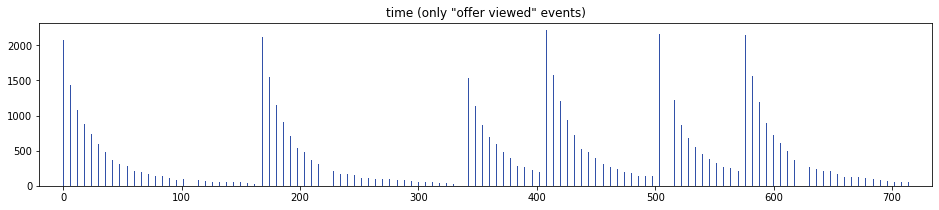

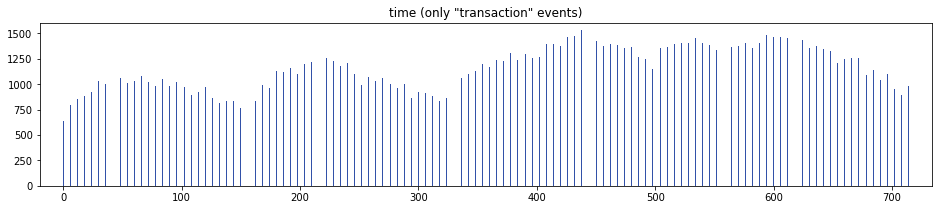

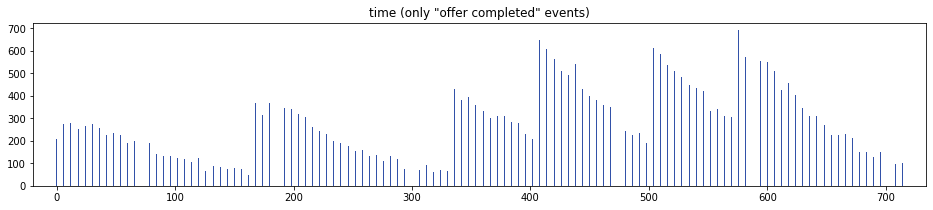

In [22]:
show_distribution(transcript, 'event', figsize=(10,4), show_percentages=True)

figsize_time = (16,3)
xlim_time = (0, transcript['time'].max())
show_distribution(transcript, 'time', figsize=figsize_time, xlim=xlim_time)
for event_type in transcript['event'].unique():
    show_distribution(transcript[transcript['event'] == event_type], 'time', title=f'time (only "{ event_type }" events)', figsize=figsize_time, xlim=xlim_time)

**How are events distributed across the people?**

Every person has between 1 and 51 events.


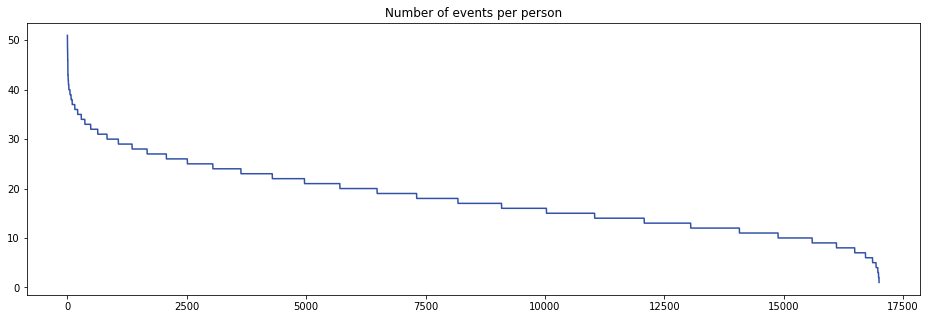

In [23]:
event_person_counts = transcript.groupby('person').size().reset_index(name="Counts")
event_person_counts = event_person_counts.sort_values(by=['Counts'], ascending=False)

plt.figure(figsize=(16,5))
plt.title('Number of events per person')
plt.plot(range(len(event_person_counts['Counts'])), event_person_counts['Counts'], color = color_blue)

print(f'Every person has between { event_person_counts["Counts"].min() } and { event_person_counts["Counts"].max() } events.')

**How many events belong to people with blank profiles?**

In [24]:
list_of_blank_profile_ids = blank_profiles['id']
transcript_only_blank_profiles = transcript.loc[transcript['person'].isin(list_of_blank_profile_ids)]
transcript_only_filled_profiles = transcript.loc[~transcript['person'].isin(list_of_blank_profile_ids)]

print(f'Transactions of people with blank profiles: { transcript_only_blank_profiles.shape[0] }')
print(f'Transactions of people with filled profiles: { transcript_only_filled_profiles.shape[0] }')

Transactions of people with blank profiles: 33772
Transactions of people with filled profiles: 272762


**Data distribution for transactions of people with complete profile:**

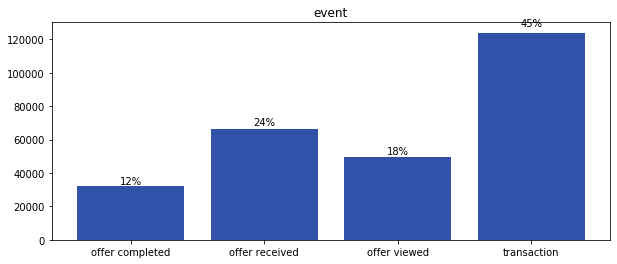

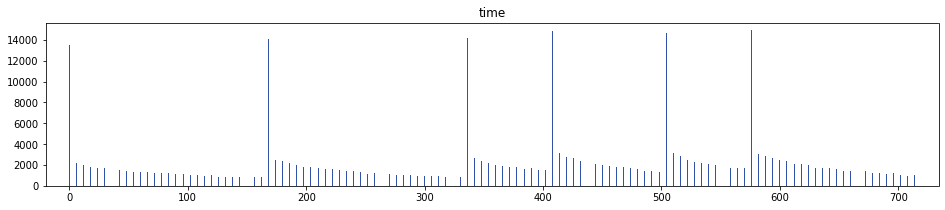

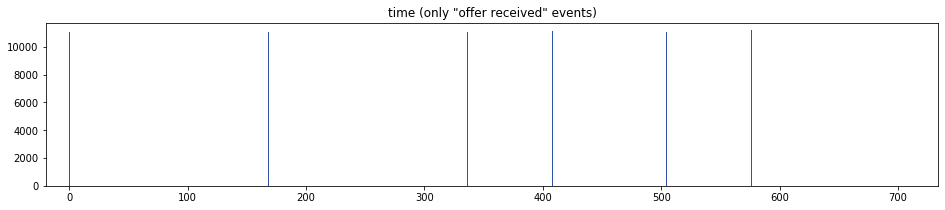

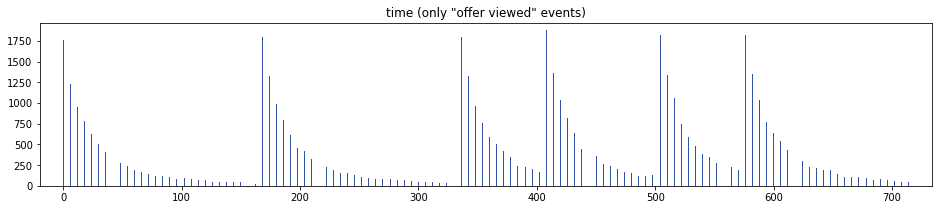

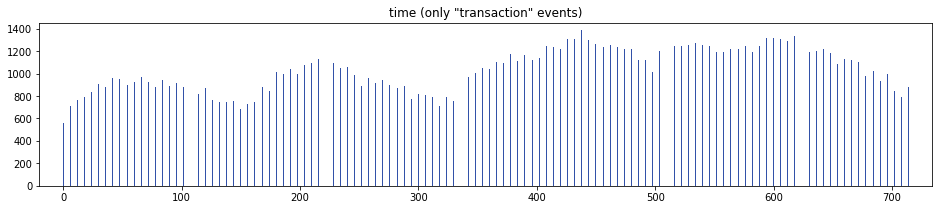

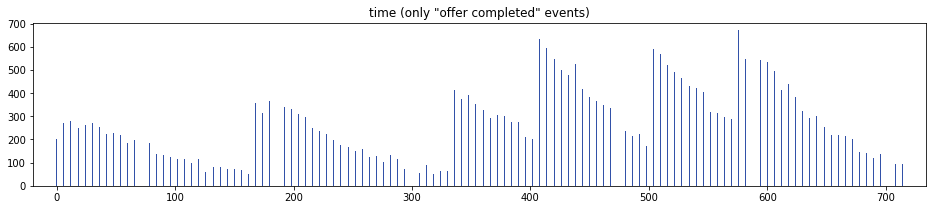

In [25]:
show_distribution(transcript_only_filled_profiles, 'event', figsize=(10,4), show_percentages=True)

figsize_time = (16,3)
xlim_time = (0, transcript['time'].max()) # Intentionally use same time line as above to maintain comparability
show_distribution(transcript_only_filled_profiles, 'time', figsize=figsize_time, xlim=xlim_time) 
for event_type in transcript_only_filled_profiles['event'].unique():
    show_distribution(transcript_only_filled_profiles[transcript_only_filled_profiles['event'] == event_type], 'time', title=f'time (only "{ event_type }" events)', figsize=figsize_time, xlim=xlim_time)

### Observations: Distribution of transaction data  

- *Different people have different numbers of events associated to them, as expected.*
- *Every person has between 1 and 51 events.*
- *We will have to make sure to shuffle the data points when using them for machine learning algorithms. They seem to be ordered by time, which also means that there are lots of bulk sections of events of the same type such as 'offer received' events when a campaign is sent.*

## Data Preprocessing

### Profile

In [26]:
# Remove all blank profiles
# There should be 14825 (= 17000 - 2175) filled profiles left
profile_preprocessed = filled_profiles.reset_index(drop=True)
assert(profile_preprocessed.shape[0] == 14825)

# Add one-hot encoding for categorical attribute gender
gender_one_hot = pd.get_dummies(profile_preprocessed.gender, prefix='gender')
profile_preprocessed = pd.concat([profile_preprocessed, gender_one_hot], axis=1)

# Drop categorical columns
profile_preprocessed = profile_preprocessed.drop(columns=['gender'])

# Use unique profile id as index
profile_preprocessed = profile_preprocessed.set_index('id', verify_integrity=True)

# Preview
profile_preprocessed.head(30)


,age,became_member_on,income,gender_F,gender_M,gender_O
id,,,,,,
0610b486422d4921ae7d2bf64640c50b,55.0,20170715,112000.0,1,0,0
78afa995795e4d85b5d9ceeca43f5fef,75.0,20170509,100000.0,1,0,0
e2127556f4f64592b11af22de27a7932,68.0,20180426,70000.0,0,1,0
389bc3fa690240e798340f5a15918d5c,65.0,20180209,53000.0,0,1,0
2eeac8d8feae4a8cad5a6af0499a211d,58.0,20171111,51000.0,0,1,0
aa4862eba776480b8bb9c68455b8c2e1,61.0,20170911,57000.0,1,0,0
e12aeaf2d47d42479ea1c4ac3d8286c6,26.0,20140213,46000.0,0,1,0
31dda685af34476cad5bc968bdb01c53,62.0,20160211,71000.0,1,0,0
62cf5e10845442329191fc246e7bcea3,49.0,20141113,52000.0,0,1,0


### Portfolio

In [27]:
portfolio_preprocessed = portfolio

# Create separate binary attributes for all channels used by an offer
channel_dummies = portfolio_preprocessed.channels.str.join('|').str.get_dummies().add_prefix('ch_')

# Create one-hot encoding for categorical attribute offer type
offer_type_one_hot = pd.get_dummies(portfolio_preprocessed.offer_type, prefix='type')

# Drop categorical columns
portfolio_preprocessed = portfolio_preprocessed.drop(columns=['offer_type', 'channels'])

# Add features to dataframe 
portfolio_preprocessed = pd.concat([portfolio_preprocessed, offer_type_one_hot, channel_dummies], axis=1)

# Use unique offer id as index
portfolio_preprocessed = portfolio_preprocessed.set_index('id', verify_integrity=True)

# Preview
portfolio_preprocessed.head(30)

,reward,difficulty,duration,type_bogo,type_discount,type_informational,ch_email,ch_mobile,ch_social,ch_web
id,,,,,,,,,,
ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,1,0,0,1,1,1,0
4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,5,1,0,0,1,1,1,1
3f207df678b143eea3cee63160fa8bed,0,0,4,0,0,1,1,1,0,1
9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,1,0,0,1,1,0,1
0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,10,0,1,0,1,0,0,1
2298d6c36e964ae4a3e7e9706d1fb8c2,3,7,7,0,1,0,1,1,1,1
fafdcd668e3743c1bb461111dcafc2a4,2,10,10,0,1,0,1,1,1,1
5a8bc65990b245e5a138643cd4eb9837,0,0,3,0,0,1,1,1,1,0
f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,1,0,0,1,1,1,1


### Transcript

#### Remove rows belonging to blank profiles

In [28]:
transcript_preprocessed = transcript_only_filled_profiles.reset_index()

# There should be 272762 (= 306534 - 33772) filled rows left
assert(transcript_preprocessed.shape[0] == 272762)

#### Extract JSON attributes offer_id and amount to separate DF columns

In [29]:
def extract_from_value_dict(value_dict, keys):
    for key in keys:
        if key in value_dict:
            return value_dict[key]
    return None

# Extract JSON attributes offer_id and amount to separate DF columns
transcript_preprocessed['amount'] = None
transcript_preprocessed['offer_id'] = None
#transcript_preprocessed.loc[transcript_preprocessed['event'] == 'offer received', ['offer_id']] = 1

transcript_preprocessed['amount'] = transcript_preprocessed['value'].apply(lambda x: extract_from_value_dict(x, ['amount']))
transcript_preprocessed['offer_id'] = transcript_preprocessed['value'].apply(lambda x: extract_from_value_dict(x, ['offer_id', 'offer id']))

# TODO: Check whether there are more variants

#### Remove transaction events and amount column since we don't need them for our calculations

In [30]:
# Remove all rows with 'transaction' events
print(f'Rows with transactions: { transcript_preprocessed.shape[0] }')
transcript_preprocessed = transcript_preprocessed.loc[transcript_preprocessed['event'] != 'transaction'].reset_index(drop=True)
print(f'Rows without transactions: { transcript_preprocessed.shape[0] }')

# Remove columns 'amount' and 'value'
transcript_preprocessed = transcript_preprocessed.drop(columns=['amount', 'value'])

# Preview
display(transcript_preprocessed.head(10))
display(transcript_preprocessed.tail(10))

Rows with transactions: 272762
Rows without transactions: 148805


,index,person,event,time,offer_id
0,0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5
2,5,389bc3fa690240e798340f5a15918d5c,offer received,0,f19421c1d4aa40978ebb69ca19b0e20d
3,7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,3f207df678b143eea3cee63160fa8bed
4,8,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,9,31dda685af34476cad5bc968bdb01c53,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
6,12,4b0da7e80e5945209a1fdddfe813dbe0,offer received,0,ae264e3637204a6fb9bb56bc8210ddfd
7,13,c27e0d6ab72c455a8bb66d980963de60,offer received,0,3f207df678b143eea3cee63160fa8bed
8,14,d53717f5400c4e84affdaeda9dd926b3,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
9,15,f806632c011441378d4646567f357a21,offer received,0,fafdcd668e3743c1bb461111dcafc2a4


,index,person,event,time,offer_id
148795,306450,9b51e8797290403b90d09d864dec4b94,offer viewed,714,3f207df678b143eea3cee63160fa8bed
148796,306455,f3e801caeafe4899b3b989b586e74ac7,offer completed,714,0b1e1539f2cc45b7b9fa7c272da2e1d7
148797,306456,f3e801caeafe4899b3b989b586e74ac7,offer completed,714,0b1e1539f2cc45b7b9fa7c272da2e1d7
148798,306470,452cdae2c68e4732a4177d3929562690,offer completed,714,fafdcd668e3743c1bb461111dcafc2a4
148799,306475,0c027f5f34dd4b9eba0a25785c611273,offer completed,714,2298d6c36e964ae4a3e7e9706d1fb8c2
148800,306483,84fb57a7fe8045a8bf6236738ee73a0f,offer viewed,714,5a8bc65990b245e5a138643cd4eb9837
148801,306490,abc4359eb34e4e2ca2349da2ddf771b6,offer viewed,714,3f207df678b143eea3cee63160fa8bed
148802,306507,8dda575c2a1d44b9ac8e8b07b93d1f8e,offer viewed,714,0b1e1539f2cc45b7b9fa7c272da2e1d7
148803,306509,8431c16f8e1d440880db371a68f82dd0,offer completed,714,fafdcd668e3743c1bb461111dcafc2a4
148804,306527,24f56b5e1849462093931b164eb803b5,offer completed,714,fafdcd668e3743c1bb461111dcafc2a4


#### Join relevant data from portfolio and profile data frames

In [31]:
transcript_joined = transcript_preprocessed # First occurence of transcript_joined
transcript_joined = transcript_joined.join(profile_preprocessed.add_prefix('prs_'), on='person')
transcript_joined = transcript_joined.join(portfolio_preprocessed.add_prefix('prt_'), on='offer_id')
assert(transcript_joined.isna().sum().sum() == 0)

# Preview
display(transcript_joined.head(10))
display(transcript_joined.tail(10))

,index,person,event,time,offer_id,prs_age,prs_became_member_on,prs_income,prs_gender_F,prs_gender_M,prs_gender_O,prt_reward,prt_difficulty,prt_duration,prt_type_bogo,prt_type_discount,prt_type_informational,prt_ch_email,prt_ch_mobile,prt_ch_social,prt_ch_web
0,0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,75.0,20170509,100000.0,1,0,0,5,5,7,1,0,0,1,1,0,1
1,2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,68.0,20180426,70000.0,0,1,0,2,10,7,0,1,0,1,1,0,1
2,5,389bc3fa690240e798340f5a15918d5c,offer received,0,f19421c1d4aa40978ebb69ca19b0e20d,65.0,20180209,53000.0,0,1,0,5,5,5,1,0,0,1,1,1,1
3,7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,3f207df678b143eea3cee63160fa8bed,58.0,20171111,51000.0,0,1,0,0,0,4,0,0,1,1,1,0,1
4,8,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,61.0,20170911,57000.0,1,0,0,5,20,10,0,1,0,1,0,0,1
5,9,31dda685af34476cad5bc968bdb01c53,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,62.0,20160211,71000.0,1,0,0,5,20,10,0,1,0,1,0,0,1
6,12,4b0da7e80e5945209a1fdddfe813dbe0,offer received,0,ae264e3637204a6fb9bb56bc8210ddfd,64.0,20170909,100000.0,0,1,0,10,10,7,1,0,0,1,1,1,0
7,13,c27e0d6ab72c455a8bb66d980963de60,offer received,0,3f207df678b143eea3cee63160fa8bed,78.0,20170616,71000.0,1,0,0,0,0,4,0,0,1,1,1,0,1
8,14,d53717f5400c4e84affdaeda9dd926b3,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,88.0,20170518,53000.0,1,0,0,5,20,10,0,1,0,1,0,0,1
9,15,f806632c011441378d4646567f357a21,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,42.0,20130811,69000.0,0,1,0,2,10,10,0,1,0,1,1,1,1


,index,person,event,time,offer_id,prs_age,prs_became_member_on,prs_income,prs_gender_F,prs_gender_M,prs_gender_O,prt_reward,prt_difficulty,prt_duration,prt_type_bogo,prt_type_discount,prt_type_informational,prt_ch_email,prt_ch_mobile,prt_ch_social,prt_ch_web
148795,306450,9b51e8797290403b90d09d864dec4b94,offer viewed,714,3f207df678b143eea3cee63160fa8bed,70.0,20171103,81000.0,1,0,0,0,0,4,0,0,1,1,1,0,1
148796,306455,f3e801caeafe4899b3b989b586e74ac7,offer completed,714,0b1e1539f2cc45b7b9fa7c272da2e1d7,27.0,20170627,40000.0,1,0,0,5,20,10,0,1,0,1,0,0,1
148797,306456,f3e801caeafe4899b3b989b586e74ac7,offer completed,714,0b1e1539f2cc45b7b9fa7c272da2e1d7,27.0,20170627,40000.0,1,0,0,5,20,10,0,1,0,1,0,0,1
148798,306470,452cdae2c68e4732a4177d3929562690,offer completed,714,fafdcd668e3743c1bb461111dcafc2a4,58.0,20180625,86000.0,0,1,0,2,10,10,0,1,0,1,1,1,1
148799,306475,0c027f5f34dd4b9eba0a25785c611273,offer completed,714,2298d6c36e964ae4a3e7e9706d1fb8c2,56.0,20171024,61000.0,0,1,0,3,7,7,0,1,0,1,1,1,1
148800,306483,84fb57a7fe8045a8bf6236738ee73a0f,offer viewed,714,5a8bc65990b245e5a138643cd4eb9837,64.0,20170615,113000.0,1,0,0,0,0,3,0,0,1,1,1,1,0
148801,306490,abc4359eb34e4e2ca2349da2ddf771b6,offer viewed,714,3f207df678b143eea3cee63160fa8bed,51.0,20140804,68000.0,0,1,0,0,0,4,0,0,1,1,1,0,1
148802,306507,8dda575c2a1d44b9ac8e8b07b93d1f8e,offer viewed,714,0b1e1539f2cc45b7b9fa7c272da2e1d7,60.0,20170908,64000.0,1,0,0,5,20,10,0,1,0,1,0,0,1
148803,306509,8431c16f8e1d440880db371a68f82dd0,offer completed,714,fafdcd668e3743c1bb461111dcafc2a4,39.0,20180627,39000.0,0,1,0,2,10,10,0,1,0,1,1,1,1
148804,306527,24f56b5e1849462093931b164eb803b5,offer completed,714,fafdcd668e3743c1bb461111dcafc2a4,48.0,20171228,80000.0,1,0,0,2,10,10,0,1,0,1,1,1,1


#### Create new data frame with one row per unique offer/person combination

In [32]:
# TODO Explicitly show that we know that offer/person combination is not unique.

# TODO Check why there seem to be two groups with row 74322

#### Create one data frame per event type 

In [33]:
offer_received_events = transcript_joined.loc[transcript_joined['event'] == 'offer received']
offer_viewed_events = transcript_joined.loc[transcript_joined['event'] == 'offer viewed']
offer_completed_events = transcript_joined.loc[transcript_joined['event'] == 'offer completed']

n_received = offer_received_events.shape[0]
n_viewed = offer_viewed_events.shape[0]
n_completed = offer_completed_events.shape[0]

print(f"Number of 'offer received' events: {n_received}")
print(f"Number of 'offer viewed' events: {n_viewed}")
print(f"Number of 'offer completed' events: {n_completed}")

assert(n_received + n_viewed + n_completed == transcript_joined.shape[0])

Number of 'offer received' events: 66501
Number of 'offer viewed' events: 49860
Number of 'offer completed' events: 32444


In [34]:
offer_received_events.head(10)

,index,person,event,time,offer_id,prs_age,prs_became_member_on,prs_income,prs_gender_F,prs_gender_M,prs_gender_O,prt_reward,prt_difficulty,prt_duration,prt_type_bogo,prt_type_discount,prt_type_informational,prt_ch_email,prt_ch_mobile,prt_ch_social,prt_ch_web
0,0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,75.0,20170509,100000.0,1,0,0,5,5,7,1,0,0,1,1,0,1
1,2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,68.0,20180426,70000.0,0,1,0,2,10,7,0,1,0,1,1,0,1
2,5,389bc3fa690240e798340f5a15918d5c,offer received,0,f19421c1d4aa40978ebb69ca19b0e20d,65.0,20180209,53000.0,0,1,0,5,5,5,1,0,0,1,1,1,1
3,7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,3f207df678b143eea3cee63160fa8bed,58.0,20171111,51000.0,0,1,0,0,0,4,0,0,1,1,1,0,1
4,8,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,61.0,20170911,57000.0,1,0,0,5,20,10,0,1,0,1,0,0,1
5,9,31dda685af34476cad5bc968bdb01c53,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,62.0,20160211,71000.0,1,0,0,5,20,10,0,1,0,1,0,0,1
6,12,4b0da7e80e5945209a1fdddfe813dbe0,offer received,0,ae264e3637204a6fb9bb56bc8210ddfd,64.0,20170909,100000.0,0,1,0,10,10,7,1,0,0,1,1,1,0
7,13,c27e0d6ab72c455a8bb66d980963de60,offer received,0,3f207df678b143eea3cee63160fa8bed,78.0,20170616,71000.0,1,0,0,0,0,4,0,0,1,1,1,0,1
8,14,d53717f5400c4e84affdaeda9dd926b3,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,88.0,20170518,53000.0,1,0,0,5,20,10,0,1,0,1,0,0,1
9,15,f806632c011441378d4646567f357a21,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,42.0,20130811,69000.0,0,1,0,2,10,10,0,1,0,1,1,1,1


#### Group transcript rows by offer_id/person combination 

In [35]:
# Group by offer_id/person combination
transcript_grouped = transcript_joined.groupby(['offer_id', 'person'], sort=False)
print(f'Number of groups: { transcript_grouped.ngroups }')

# Display some test groups
display(transcript_grouped.get_group(("9b98b8c7a33c4b65b9aebfe6a799e6d9", "78afa995795e4d85b5d9ceeca43f5fef")))
display(transcript_grouped.get_group(("3f207df678b143eea3cee63160fa8bed", "f806632c011441378d4646567f357a21")))


Number of groups: 55222


,index,person,event,time,offer_id,prs_age,prs_became_member_on,prs_income,prs_gender_F,prs_gender_M,prs_gender_O,prt_reward,prt_difficulty,prt_duration,prt_type_bogo,prt_type_discount,prt_type_informational,prt_ch_email,prt_ch_mobile,prt_ch_social,prt_ch_web
0,0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,75.0,20170509,100000.0,1,0,0,5,5,7,1,0,0,1,1,0,1
12984,15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,75.0,20170509,100000.0,1,0,0,5,5,7,1,0,0,1,1,0,1
23495,47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,75.0,20170509,100000.0,1,0,0,5,5,7,1,0,0,1,1,0,1


,index,person,event,time,offer_id,prs_age,prs_became_member_on,prs_income,prs_gender_F,prs_gender_M,prs_gender_O,prt_reward,prt_difficulty,prt_duration,prt_type_bogo,prt_type_discount,prt_type_informational,prt_ch_email,prt_ch_mobile,prt_ch_social,prt_ch_web
121222,245137,f806632c011441378d4646567f357a21,offer received,576,3f207df678b143eea3cee63160fa8bed,42.0,20130811,69000.0,0,1,0,0,0,4,0,0,1,1,1,0,1
139722,271785,f806632c011441378d4646567f357a21,offer viewed,600,3f207df678b143eea3cee63160fa8bed,42.0,20130811,69000.0,0,1,0,0,0,4,0,0,1,1,1,0,1


#### Create training examples (one training example for every 'offer received' event)
We iterate over each group by using the _apply_ function. Inside of each group, we iterate over all 'offer received' events (most often there is only one of these, but there are cases where the same offer was sent to the same user multiple times) and create one training example for each 'offer received' event. A created training example is considered only considered as a positive example if the following conditions hold:

- There is an **'offer completed'** event during the validity period of the offer, for the same customer/offer_id as the 'offer received' event the training example is being created from. If there are **multiple** relevant 'offer completed' events, we pick the latest one (that is still during the validity period).
- There is an **'offer viewed'** event **between the offer's start and the time of the 'offer completed'** event, for the same customer/offer_id as the 'offer received' event the training example is being created from.

In [36]:
import datetime
import time
import pickle
import os

# Prepare cache directory
cache_dir = os.path.join("./cache")  # where to store cache files
os.makedirs(cache_dir, exist_ok=True)  # ensure cache directory exists

# For a given group, create as many training examples as there are 'offer received' events
g_create_training_examples_for_group_i = 0
def create_training_examples_for_group(group):

    all_completed_events_in_group = group.loc[(group['event'] == 'offer completed')]
    all_viewed_events_in_group = group.loc[(group['event'] == 'offer viewed')]

    created_training_examples_df = pd.DataFrame(columns=group.columns)
    
    # Attention: A person/offer combination is not unique. 
    # Hence, there might be multiple 'offer received' events in a group.
    # We will generate one training example for each 'offer received' event and treat each 
    # occurence of a received offer as a new 'experiment'.
    offer_received_events_df = group.loc[group['event'] == 'offer received']
    
    for index, row in offer_received_events_df.iterrows():
        
        # TODO Pass variables as func args instead of using global
        global g_create_training_examples_for_group_i, n_received, create_training_examples_started
        g_create_training_examples_for_group_i = g_create_training_examples_for_group_i + 1
        
        # Print out progress information
        if(g_create_training_examples_for_group_i % 100 == 0):
            sec_elapsed = time.time() - create_training_examples_started
            progress_percent = (g_create_training_examples_for_group_i / n_received)*100
            print('\r', "Number of events processed after %is: %i / %i (%.1f %%)" % (sec_elapsed, g_create_training_examples_for_group_i, n_received, progress_percent), end='          ')
        
        # Set negative class target label by default
        row['target_label'] = 0
        
        # Add as negative training example if no 'offer completed' events found in group
        if(all_completed_events_in_group.shape[0] < 1):
            #print("No 'offer completed' events in group, training example can't be positive")
            created_training_examples_df = created_training_examples_df.append(row)
            continue

        # Add as negative training example if no 'offer viewed' events found in group
        if(all_viewed_events_in_group.shape[0] < 1):
            #print("No 'offer viewed' events in group, training example can't be positive")
            created_training_examples_df = created_training_examples_df.append(row)
            continue
        
        # Check whether there is a 'offer completed' event during the current duration 
        start_time = row['time']
        end_time = start_time + row['prt_duration']
        relevant_completed_events = group.loc[(group['event'] == 'offer completed') & (group['time'] >= start_time) & (group['time'] <= end_time)]
        #relevant_completed_events = all_completed_events_in_group.loc[(all_completed_events_in_group['time'] >= start_time) & (all_completed_events_in_group['time'] <= end_time)]
        
        # Add as negative training example if there is no 'offer completed' event during the current duration
        if(relevant_completed_events.shape[0] < 1):
            created_training_examples_df = created_training_examples_df.append(row)
            continue        
            
        # Use the latest completed event that is still relevant, to allow for overlapping offer timelines 
        completed_event_time = relevant_completed_events.tail(1).reset_index(drop=True).iloc[0]['time']
        
        # Get all 'offer viewed' events that occured after the current 'offer received' event and before the latest relevant 'offer completed' event
        relevant_viewed_events = group.loc[(group['event'] == 'offer viewed') & (group['time'] >= start_time) & (group['time'] <= completed_event_time)]
        #relevant_viewed_events = all_viewed_events_in_group.loc[(all_viewed_events_in_group['time'] >= start_time) & (all_viewed_events_in_group['time'] <= completed_event_time)]
        
        # All requirements given, make this a positive training example!
        if(relevant_viewed_events.shape[0] > 0):
            row['target_label'] = 1
            
            #print('\n\n\n++++++++')
            #print(f'Start time: {start_time}')
            #print(f'End time: {end_time}')
            #print('----- GROUP:')
            #display(group)
            #print('\n----- RELEVANT COMPLETED EVENTS:')
            #display(relevant_completed_events)
            #print('\n----- COMPLETED EVENT TIME:')
            #display(completed_event_time)
            #print('\n----- RELEVANT VIEWED EVENTS:')
            #display(relevant_viewed_events)
            #print('\n----- All requirements given, make this a positive training example!')
            
        created_training_examples_df = created_training_examples_df.append(row)

    #display(created_training_examples_df)
    return created_training_examples_df

# For a given group, create as many training examples as there are 'offer received' events
def create_training_examples(transcript_grouped_df, cache_dir=cache_dir, cache_file="training_examples.pkl"):
    
    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = pickle.load(f)
            print("Reading training example data from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay
    
    # If no cache could be loaded, calculate training examples from scratch
    if cache_data is None:
        training_examples = transcript_grouped_df.apply(create_training_examples_for_group)
        
        # Write to cache file for future runs
        if cache_file is not None:
            cache_data = dict(training_examples=training_examples)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                pickle.dump(cache_data, f)
            print("Wrote computed training examples to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        training_examples = cache_data['training_examples']
    
    return training_examples


In [37]:
# Create training examples for all existing 'offer received' events
create_training_examples_started = time.time()
training_examples = create_training_examples(transcript_grouped)
create_training_examples_ended = time.time()
print("Creating training examples took %i seconds." % (create_training_examples_ended - create_training_examples_started))



Reading training example data from cache file: training_examples.pkl
Creating training examples took 0 seconds.


In [38]:
assert(training_examples.shape[0] == n_received)
training_examples = training_examples.reset_index(drop=True).astype({'target_label': 'int8'})
display(training_examples.head(10))

,index,person,event,time,offer_id,prs_age,prs_became_member_on,prs_income,prs_gender_F,prs_gender_M,prs_gender_O,prt_reward,prt_difficulty,prt_duration,prt_type_bogo,prt_type_discount,prt_type_informational,prt_ch_email,prt_ch_mobile,prt_ch_social,prt_ch_web,target_label
0,0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,75.0,20170509,100000.0,1,0,0,5,5,7,1,0,0,1,1,0,1,0
1,2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,68.0,20180426,70000.0,0,1,0,2,10,7,0,1,0,1,1,0,1,0
2,5,389bc3fa690240e798340f5a15918d5c,offer received,0,f19421c1d4aa40978ebb69ca19b0e20d,65.0,20180209,53000.0,0,1,0,5,5,5,1,0,0,1,1,1,1,0
3,201577,389bc3fa690240e798340f5a15918d5c,offer received,504,f19421c1d4aa40978ebb69ca19b0e20d,65.0,20180209,53000.0,0,1,0,5,5,5,1,0,0,1,1,1,1,0
4,7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,3f207df678b143eea3cee63160fa8bed,58.0,20171111,51000.0,0,1,0,0,0,4,0,0,1,1,1,0,1,0
5,8,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,61.0,20170911,57000.0,1,0,0,5,20,10,0,1,0,1,0,0,1,0
6,9,31dda685af34476cad5bc968bdb01c53,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,62.0,20160211,71000.0,1,0,0,5,20,10,0,1,0,1,0,0,1,0
7,12,4b0da7e80e5945209a1fdddfe813dbe0,offer received,0,ae264e3637204a6fb9bb56bc8210ddfd,64.0,20170909,100000.0,0,1,0,10,10,7,1,0,0,1,1,1,0,0
8,201583,4b0da7e80e5945209a1fdddfe813dbe0,offer received,504,ae264e3637204a6fb9bb56bc8210ddfd,64.0,20170909,100000.0,0,1,0,10,10,7,1,0,0,1,1,1,0,1
9,13,c27e0d6ab72c455a8bb66d980963de60,offer received,0,3f207df678b143eea3cee63160fa8bed,78.0,20170616,71000.0,1,0,0,0,0,4,0,0,1,1,1,0,1,0


#### Perform some tests to validate created training example labels

In [39]:
def assert_label(index, label):
    assert(training_examples.loc[training_examples['index'] == index].reset_index()['target_label'][0] == label)

# Test group 1
display(transcript_grouped.get_group(("2298d6c36e964ae4a3e7e9706d1fb8c2", "2e87ba0fba1a4d1a8614af771f07a94d")))
assert_label(45, 0)
assert_label(53222, 1)

# Test group 2
display(transcript_grouped.get_group(("ae264e3637204a6fb9bb56bc8210ddfd", "4b0da7e80e5945209a1fdddfe813dbe0")))
assert_label(12, 0)
assert_label(201583, 1)

# Test group 3
display(transcript_grouped.get_group(("0b1e1539f2cc45b7b9fa7c272da2e1d7", "ff737c250d2343729ade04c4f6eb1001")))
assert_label(257872, 0)


,index,person,event,time,offer_id,prs_age,prs_became_member_on,prs_income,prs_gender_F,prs_gender_M,prs_gender_O,prt_reward,prt_difficulty,prt_duration,prt_type_bogo,prt_type_discount,prt_type_informational,prt_ch_email,prt_ch_mobile,prt_ch_social,prt_ch_web
34,45,2e87ba0fba1a4d1a8614af771f07a94d,offer received,0,2298d6c36e964ae4a3e7e9706d1fb8c2,67.0,20170226,76000.0,0,1,0,3,7,7,0,1,0,1,1,1,1
17641,24223,2e87ba0fba1a4d1a8614af771f07a94d,offer viewed,30,2298d6c36e964ae4a3e7e9706d1fb8c2,67.0,20170226,76000.0,0,1,0,3,7,7,0,1,0,1,1,1,1
20120,31110,2e87ba0fba1a4d1a8614af771f07a94d,offer completed,54,2298d6c36e964ae4a3e7e9706d1fb8c2,67.0,20170226,76000.0,0,1,0,3,7,7,0,1,0,1,1,1,1
24186,53222,2e87ba0fba1a4d1a8614af771f07a94d,offer received,168,2298d6c36e964ae4a3e7e9706d1fb8c2,67.0,20170226,76000.0,0,1,0,3,7,7,0,1,0,1,1,1,1
35220,65856,2e87ba0fba1a4d1a8614af771f07a94d,offer viewed,168,2298d6c36e964ae4a3e7e9706d1fb8c2,67.0,20170226,76000.0,0,1,0,3,7,7,0,1,0,1,1,1,1
35221,65858,2e87ba0fba1a4d1a8614af771f07a94d,offer completed,168,2298d6c36e964ae4a3e7e9706d1fb8c2,67.0,20170226,76000.0,0,1,0,3,7,7,0,1,0,1,1,1,1


,index,person,event,time,offer_id,prs_age,prs_became_member_on,prs_income,prs_gender_F,prs_gender_M,prs_gender_O,prt_reward,prt_difficulty,prt_duration,prt_type_bogo,prt_type_discount,prt_type_informational,prt_ch_email,prt_ch_mobile,prt_ch_social,prt_ch_web
6,12,4b0da7e80e5945209a1fdddfe813dbe0,offer received,0,ae264e3637204a6fb9bb56bc8210ddfd,64.0,20170909,100000.0,0,1,0,10,10,7,1,0,0,1,1,1,0
22638,42028,4b0da7e80e5945209a1fdddfe813dbe0,offer viewed,102,ae264e3637204a6fb9bb56bc8210ddfd,64.0,20170909,100000.0,0,1,0,10,10,7,1,0,0,1,1,1,0
97377,201583,4b0da7e80e5945209a1fdddfe813dbe0,offer received,504,ae264e3637204a6fb9bb56bc8210ddfd,64.0,20170909,100000.0,0,1,0,10,10,7,1,0,0,1,1,1,0
110828,218400,4b0da7e80e5945209a1fdddfe813dbe0,offer viewed,510,ae264e3637204a6fb9bb56bc8210ddfd,64.0,20170909,100000.0,0,1,0,10,10,7,1,0,0,1,1,1,0
110829,218402,4b0da7e80e5945209a1fdddfe813dbe0,offer completed,510,ae264e3637204a6fb9bb56bc8210ddfd,64.0,20170909,100000.0,0,1,0,10,10,7,1,0,0,1,1,1,0


,index,person,event,time,offer_id,prs_age,prs_became_member_on,prs_income,prs_gender_F,prs_gender_M,prs_gender_O,prt_reward,prt_difficulty,prt_duration,prt_type_bogo,prt_type_discount,prt_type_informational,prt_ch_email,prt_ch_mobile,prt_ch_social,prt_ch_web
132365,257872,ff737c250d2343729ade04c4f6eb1001,offer received,576,0b1e1539f2cc45b7b9fa7c272da2e1d7,72.0,20150404,65000.0,1,0,0,5,20,10,0,1,0,1,0,0,1


#### Compute class distribution

# Prepare data sets & handle class imbalances 

#### Helper functions

In [40]:
def print_class_balance_info(examples, label_col_name):
    pos_n = examples.loc[examples[label_col_name] == 1].shape[0]
    neg_n = examples.loc[examples[label_col_name] == 0].shape[0]
    percentage_of_positives = (pos_n / (neg_n + pos_n))*100
    print(f'Examples: { pos_n } positive / { neg_n } negative ({ neg_n + pos_n } total)') 
    print("Percentage of positive examples: %.1f %%" % percentage_of_positives)

In [41]:
def print_data_set_statistics(X, y, X_train, y_train, X_val, y_val, X_test, y_test):
    X_n = X.shape[0]
    X_train_n = X_train.shape[0]
    X_val_n = X_val.shape[0]
    X_test_n = X_test.shape[0]

    # Print statistics about created data sets
    print('{:<14s}{:>8s}{:>15s}'.format('Data Set', 'Rows', 'Positives'))
    print('-' * 55)
    print('{:<14s}{:>8s}{:>15}'.format('Training', '%i' % (X_train_n), '%.4f %%' % ((X_train.loc[y_train==1].shape[0] / X_train_n)*100)))
    print('{:<14s}{:>8s}{:>15}'.format('Validation', '%i' % (X_val_n), '%.4f %%' % ((X_val.loc[y_val==1].shape[0] / X_val_n)*100)))
    print('{:<14s}{:>8s}{:>15}'.format('Test', '%i' % (X_test_n), '%.4f %%' % ((X_test.loc[y_test==1].shape[0] / X_test_n)*100)))
    print('-' * 55)
    print('{:<14s}{:>8s}'.format('Total', str(X_train_n + X_val_n + X_test_n)))
    #print('{:<14s}{:>8s}{:>15}'.format('Total', str(X_train_n + X_val_n + X_test_n), '%.4f %%' % ((X.loc[y==1].shape[0] / X_n)*100)))

## Handle class imbalance with downsampling

#### Show class distribution (unsampled training examples)

In [42]:
print_class_balance_info(training_examples, 'target_label')

Examples: 1490 positive / 65011 negative (66501 total)
Percentage of positive examples: 2.2 %


#### Create overall data set and labels (not split into train/validation/test yet)

In [43]:
y = training_examples['target_label']
X = training_examples.drop(columns=['index', 'event', 'person', 'time', 'offer_id', 'prs_became_member_on', 'target_label'])

### Select features

#### Display correlation matrix of features

### Create training, validation and test data sets

In [44]:
from sklearn.model_selection import train_test_split

# Split data into train (60%), validation (20%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, shuffle=True, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, shuffle=True, stratify=y_test)

assert(training_examples.shape[0] == X_train.shape[0] + X_val.shape[0] + X_test.shape[0])

print_data_set_statistics(X, y, X_train, y_train, X_val, y_val, X_test, y_test)

Data Set          Rows      Positives
-------------------------------------------------------
Training         39900       2.2406 %
Validation       13300       2.2406 %
Test             13301       2.2404 %
-------------------------------------------------------
Total            66501


#### Perform sampling on training set

In [45]:
import numpy as np

def create_similar_examples(originals, frac, cols_to_vary, variance):
    created = originals.sample(frac=frac, random_state=1, replace=(True if frac > 1 else False)).copy()
    
    for col in cols_to_vary:
        noise = np.random.normal(1, variance, created.shape[0])
        #display(noise)
        created[col] = created[col] * noise
    
    return created

In [46]:
test_synthetic_examples_input = X_train.head(5)

display(test_synthetic_examples_input)
display(create_similar_examples(test_synthetic_examples_input, 2.0, ['prs_age', 'prs_income', 'prt_reward', 'prt_difficulty', 'prt_duration'], 0.03))

,prs_age,prs_income,prs_gender_F,prs_gender_M,prs_gender_O,prt_reward,prt_difficulty,prt_duration,prt_type_bogo,prt_type_discount,prt_type_informational,prt_ch_email,prt_ch_mobile,prt_ch_social,prt_ch_web
20702,51.0,36000.0,0,1,0,2,10,7,0,1,0,1,1,0,1
24035,36.0,67000.0,0,1,0,5,5,5,1,0,0,1,1,1,1
64113,85.0,58000.0,0,1,0,5,20,10,0,1,0,1,0,0,1
33410,41.0,34000.0,0,1,0,5,20,10,0,1,0,1,0,0,1
35995,80.0,96000.0,0,1,0,2,10,10,0,1,0,1,1,1,1


,prs_age,prs_income,prs_gender_F,prs_gender_M,prs_gender_O,prt_reward,prt_difficulty,prt_duration,prt_type_bogo,prt_type_discount,prt_type_informational,prt_ch_email,prt_ch_mobile,prt_ch_social,prt_ch_web
33410,40.381892,33765.228271,0,1,0,5.14438,19.5183,9.61997,0,1,0,1,0,0,1
35995,79.733313,95805.348560,0,1,0,2.02023,10.1004,9.44136,0,1,0,1,1,1,1
20702,50.098855,36989.283226,0,1,0,2.04521,9.50149,7.20652,0,1,0,1,1,0,1
24035,34.993303,64941.004250,0,1,0,5.05449,5.00724,4.80134,1,0,0,1,1,1,1
33410,41.033403,35083.782114,0,1,0,5.03408,20.8947,10.1517,0,1,0,1,0,0,1
20702,50.529229,34284.492250,0,1,0,1.91419,10.0074,6.69397,0,1,0,1,1,0,1
20702,53.594656,34577.756430,0,1,0,1.99065,9.54667,6.94967,0,1,0,1,1,0,1
24035,36.906218,68107.607506,0,1,0,5.19099,5.23168,5.16422,1,0,0,1,1,1,1
35995,81.163925,94397.853809,0,1,0,1.98235,10.0985,9.82927,0,1,0,1,1,1,1
35995,81.288227,92643.778148,0,1,0,1.9095,9.99776,9.66065,0,1,0,1,1,1,1


In [47]:
# TEST: Downsample negative examples of training set

examples_train = pd.concat([y_train, X_train], axis=1)

pos_examples = examples_train.loc[examples_train['target_label'] == 1]
neg_examples = examples_train.loc[examples_train['target_label'] == 0]

# Downsample negative class (by dropping examples randomly)
downsampling_factor = 1.0
neg_examples_sampled = neg_examples.sample(frac=downsampling_factor, random_state=1)

# Upsample positive class (by creating synthetic similar examples)
upsampling_factor = 5.0
cols_to_vary = ['prs_age', 'prs_income', 'prt_reward', 'prt_difficulty', 'prt_duration']
variance = 0.03
synthetic_pos_examples = create_similar_examples(pos_examples, upsampling_factor, cols_to_vary, variance)
pos_examples_sampled = pd.concat([pos_examples, synthetic_pos_examples], axis=0)

examples_train_sampled = pd.concat([pos_examples_sampled, neg_examples_sampled], axis=0).sample(frac=1, random_state=1)

y_train_sampled = examples_train_sampled['target_label']
X_train_sampled = examples_train_sampled.drop(columns=['target_label'])

print_class_balance_info(examples_train_sampled, 'target_label')

Examples: 5364 positive / 39006 negative (44370 total)
Percentage of positive examples: 12.1 %


In [48]:
# Actually use sampled version of training set
X_train = X_train_sampled
y_train = y_train_sampled

##### Show class distribution after sampling

In [49]:
print_data_set_statistics(X, y, X_train, y_train, X_val, y_val, X_test, y_test)

Data Set          Rows      Positives
-------------------------------------------------------
Training         44370      12.0892 %
Validation       13300       2.2406 %
Test             13301       2.2404 %
-------------------------------------------------------
Total            70971


#### Normalize data sets

In [50]:
display(X_train.head(5))

,prs_age,prs_income,prs_gender_F,prs_gender_M,prs_gender_O,prt_reward,prt_difficulty,prt_duration,prt_type_bogo,prt_type_discount,prt_type_informational,prt_ch_email,prt_ch_mobile,prt_ch_social,prt_ch_web
63667,54.0,117000.0,0,1,0,0,0,4,0,0,1,1,1,0,1
51352,57.0,65000.0,0,1,0,5,20,10,0,1,0,1,0,0,1
42940,36.0,56000.0,0,1,0,5,5,7,1,0,0,1,1,0,1
35362,36.0,42000.0,0,1,0,3,7,7,0,1,0,1,1,1,1
41257,52.0,95000.0,0,1,0,0,0,4,0,0,1,1,1,0,1


In [51]:
# Normalize a dataset for certain columns only, given a pre-computed set of min and max values
def normalize_columns(X, cols_to_normalize, norm_min_vals, norm_max_vals):
    X_normalized = X.copy()
    for col_name in cols_to_normalize:
        X_normalized[col_name] = (X_normalized[col_name] - norm_min_vals[col_name]) / (norm_max_vals[col_name] - norm_min_vals[col_name])
    return X_normalized

In [52]:
cols_to_normalize = ['prs_age', 'prs_income', 'prt_difficulty', 'prt_duration', 'prt_reward']

# Compute normalization data only for training set and use for all data sets to prevent data leakage
norm_min_vals = X_train[cols_to_normalize].min()
norm_max_vals = X_train[cols_to_normalize].max()

# Create normalized training data set
X_train_normalized = normalize_columns(X_train, cols_to_normalize, norm_min_vals, norm_max_vals)
X_val_normalized = normalize_columns(X_val, cols_to_normalize, norm_min_vals, norm_max_vals)
X_test_normalized = normalize_columns(X_test, cols_to_normalize, norm_min_vals, norm_max_vals)
    
# Display normalization parameters
print('Normalization parameters calculated from training set:')
display(norm_min_vals, norm_max_vals)

Normalization parameters calculated from training set:


prs_age              17.609880
prs_income        28483.819159
prt_difficulty        0.000000
prt_duration          3.000000
prt_reward            0.000000
dtype: float64

prs_age              107.036887
prs_income        127142.272759
prt_difficulty        22.350060
prt_duration          10.876492
prt_reward            10.889963
dtype: float64

#### Compare orginal and normalized data sets

In [53]:
print('\n','-' * 50)
print('Original training set data:')
display(X_train.head(5))
print('Normalized training set data:')
display(X_train_normalized.head(5))

print('\n','-' * 50)
print('Original validation set data:')
display(X_val.head(5))
print('Normalized validation set data:')
display(X_val_normalized.head(5))

print('\n','-' * 50)
print('Original test set data:')
display(X_test.head(5))
print('Normalized test set data:')
display(X_test_normalized.head(5))


 --------------------------------------------------
Original training set data:


,prs_age,prs_income,prs_gender_F,prs_gender_M,prs_gender_O,prt_reward,prt_difficulty,prt_duration,prt_type_bogo,prt_type_discount,prt_type_informational,prt_ch_email,prt_ch_mobile,prt_ch_social,prt_ch_web
63667,54.0,117000.0,0,1,0,0,0,4,0,0,1,1,1,0,1
51352,57.0,65000.0,0,1,0,5,20,10,0,1,0,1,0,0,1
42940,36.0,56000.0,0,1,0,5,5,7,1,0,0,1,1,0,1
35362,36.0,42000.0,0,1,0,3,7,7,0,1,0,1,1,1,1
41257,52.0,95000.0,0,1,0,0,0,4,0,0,1,1,1,0,1


Normalized training set data:


,prs_age,prs_income,prs_gender_F,prs_gender_M,prs_gender_O,prt_reward,prt_difficulty,prt_duration,prt_type_bogo,prt_type_discount,prt_type_informational,prt_ch_email,prt_ch_mobile,prt_ch_social,prt_ch_web
63667,0.406925,0.897198,0,1,0,0,0,0.12696,0,0,1,1,1,0,1
51352,0.440472,0.370127,0,1,0,0.459138,0.894852,0.888721,0,1,0,1,0,0,1
42940,0.205644,0.278903,0,1,0,0.459138,0.223713,0.50784,1,0,0,1,1,0,1
35362,0.205644,0.137000,0,1,0,0.275483,0.313198,0.50784,0,1,0,1,1,1,1
41257,0.384561,0.674207,0,1,0,0,0,0.12696,0,0,1,1,1,0,1



 --------------------------------------------------
Original validation set data:


,prs_age,prs_income,prs_gender_F,prs_gender_M,prs_gender_O,prt_reward,prt_difficulty,prt_duration,prt_type_bogo,prt_type_discount,prt_type_informational,prt_ch_email,prt_ch_mobile,prt_ch_social,prt_ch_web
3098,52.0,51000.0,1,0,0,5,20,10,0,1,0,1,0,0,1
54708,55.0,82000.0,1,0,0,5,20,10,0,1,0,1,0,0,1
40692,60.0,51000.0,0,1,0,10,10,5,1,0,0,1,1,1,1
17962,70.0,79000.0,0,1,0,5,20,10,0,1,0,1,0,0,1
29087,50.0,110000.0,1,0,0,3,7,7,0,1,0,1,1,1,1


Normalized validation set data:


,prs_age,prs_income,prs_gender_F,prs_gender_M,prs_gender_O,prt_reward,prt_difficulty,prt_duration,prt_type_bogo,prt_type_discount,prt_type_informational,prt_ch_email,prt_ch_mobile,prt_ch_social,prt_ch_web
3098,0.384561,0.228224,1,0,0,0.459138,0.894852,0.888721,0,1,0,1,0,0,1
54708,0.418108,0.542439,1,0,0,0.459138,0.894852,0.888721,0,1,0,1,0,0,1
40692,0.474019,0.228224,0,1,0,0.918277,0.447426,0.25392,1,0,0,1,1,1,1
17962,0.585842,0.512031,0,1,0,0.459138,0.894852,0.888721,0,1,0,1,0,0,1
29087,0.362196,0.826246,1,0,0,0.275483,0.313198,0.50784,0,1,0,1,1,1,1



 --------------------------------------------------
Original test set data:


,prs_age,prs_income,prs_gender_F,prs_gender_M,prs_gender_O,prt_reward,prt_difficulty,prt_duration,prt_type_bogo,prt_type_discount,prt_type_informational,prt_ch_email,prt_ch_mobile,prt_ch_social,prt_ch_web
24812,86.0,99000.0,1,0,0,3,7,7,0,1,0,1,1,1,1
63820,52.0,37000.0,0,1,0,5,5,7,1,0,0,1,1,0,1
23890,57.0,57000.0,1,0,0,0,0,3,0,0,1,1,1,1,0
47244,48.0,60000.0,0,1,0,5,5,7,1,0,0,1,1,0,1
50044,53.0,65000.0,1,0,0,10,10,7,1,0,0,1,1,1,0


Normalized test set data:


,prs_age,prs_income,prs_gender_F,prs_gender_M,prs_gender_O,prt_reward,prt_difficulty,prt_duration,prt_type_bogo,prt_type_discount,prt_type_informational,prt_ch_email,prt_ch_mobile,prt_ch_social,prt_ch_web
24812,0.764759,0.714751,1,0,0,0.275483,0.313198,0.50784,0,1,0,1,1,1,1
63820,0.384561,0.086320,0,1,0,0.459138,0.223713,0.50784,1,0,0,1,1,0,1
23890,0.440472,0.289039,1,0,0,0,0,0,0,0,1,1,1,1,0
47244,0.339832,0.319447,0,1,0,0.459138,0.223713,0.50784,1,0,0,1,1,0,1
50044,0.395743,0.370127,1,0,0,0.918277,0.447426,0.50784,1,0,0,1,1,1,0


#### Display correlation matrix of features

In [54]:
display(X_train_normalized.head(3))
corr_matrix = X.astype('float32').corr().abs().round(1)
display(corr_matrix)

,prs_age,prs_income,prs_gender_F,prs_gender_M,prs_gender_O,prt_reward,prt_difficulty,prt_duration,prt_type_bogo,prt_type_discount,prt_type_informational,prt_ch_email,prt_ch_mobile,prt_ch_social,prt_ch_web
63667,0.406925,0.897198,0,1,0,0,0,0.12696,0,0,1,1,1,0,1
51352,0.440472,0.370127,0,1,0,0.459138,0.894852,0.888721,0,1,0,1,0,0,1
42940,0.205644,0.278903,0,1,0,0.459138,0.223713,0.50784,1,0,0,1,1,0,1


,prs_age,prs_income,prs_gender_F,prs_gender_M,prs_gender_O,prt_reward,prt_difficulty,prt_duration,prt_type_bogo,prt_type_discount,prt_type_informational,prt_ch_email,prt_ch_mobile,prt_ch_social,prt_ch_web
prs_age,1.0,0.3,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0
prs_income,0.3,1.0,0.2,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0
prs_gender_F,0.1,0.2,1.0,1.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0
prs_gender_M,0.1,0.2,1.0,1.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0
prs_gender_O,0.0,0.0,0.1,0.1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0
prt_reward,0.0,0.0,0.0,0.0,0.0,1.0,0.5,0.2,0.8,0.3,0.6,NaN,0.1,0.3,0.1
prt_difficulty,0.0,0.0,0.0,0.0,0.0,0.5,1.0,0.8,0.0,0.6,0.7,NaN,0.7,0.2,0.2
prt_duration,0.0,0.0,0.0,0.0,0.0,0.2,0.8,1.0,0.2,0.7,0.7,NaN,0.5,0.2,0.3
prt_type_bogo,0.0,0.0,0.0,0.0,0.0,0.8,0.0,0.2,1.0,0.7,0.4,NaN,0.3,0.2,0.1
prt_type_discount,0.0,0.0,0.0,0.0,0.0,0.3,0.6,0.7,0.7,1.0,0.4,NaN,0.4,0.2,0.4


#### Create CSV files

In [55]:
def create_csv(X, y, filename, data_dir):
    '''Merges features and labels and converts them into one csv file with labels in the first column.
       :param x: Data features
       :param y: Data labels
       :param file_name: Name of csv file, ex. 'train.csv'
       :param data_dir: The directory where files will be saved
       '''
    os.makedirs(data_dir, exist_ok=True)    
    pd.concat([pd.DataFrame(y), pd.DataFrame(X)], axis=1).to_csv(os.path.join(data_dir, filename), header=False, index=False)
    print('CSV file created: ', os.path.join(data_dir, filename))

In [56]:
data_dir = 'data_csv'
create_csv(X_train_normalized, y_train, 'train.csv', data_dir)
create_csv(X_val_normalized, y_val, 'validation.csv', data_dir)

CSV file created:  data_csv/train.csv
CSV file created:  data_csv/validation.csv


In [57]:
# Also create CSV for test data, but without labels
pd.DataFrame(X_test_normalized).to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)

#### Prepare data to be used by estimators (directly): Numpy Array / Protobuf

In [58]:
import pandas as pd
import boto3
import sagemaker
import sagemaker.amazon.common as smac
import io

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()

prefix = 'project_starbucks_data'

# Create numpy arrays for estimators that use protobuf 
X_train_normalized_np = X_train_normalized.to_numpy(dtype='float32')
y_train_np = y_train.to_numpy(dtype='float32')

X_val_normalized_np = X_val_normalized.to_numpy(dtype='float32')
y_val_np = y_val.to_numpy(dtype='float32')




#key = 'linearlearner'
#boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, key, 'train')).upload_fileobj(buf)

#s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
#s3_train_location = 's3://{}/{}/{}/train'.format(bucket, prefix, key)

#s3_train_location = sagemaker_session.upload_data(path=os.path.join(data_dir, 'train.csv'), bucket=bucket, key_prefix=prefix)
#s3_val_location = sagemaker_session.upload_data(path=os.path.join(data_dir, 'validation.csv'), bucket=bucket, key_prefix=prefix)

#### Prepare data to be used by estimators (via S3): CSV Upload


In [59]:
# Also upload CSV files to S3 for estimators, e.g. PyTorch
#input_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)
s3_train_location = sagemaker_session.upload_data(path=os.path.join(data_dir, 'train.csv'), bucket=bucket, key_prefix=prefix)
s3_val_location = sagemaker_session.upload_data(path=os.path.join(data_dir, 'validation.csv'), bucket=bucket, key_prefix=prefix)
s3_test_location = sagemaker_session.upload_data(path=os.path.join(data_dir, 'test.csv'), bucket=bucket, key_prefix=prefix)

# Try & evaluate different models

#### Helper functions

In [60]:
def evaluate(predictor, test_features, test_labels, verbose=True):
    """
    Evaluate a model on a test set given the prediction endpoint.  
    Return binary classification metrics.
    :param predictor: A prediction endpoint
    :param test_features: Test features
    :param test_labels: Class labels for test data
    :param verbose: If True, prints a table of all performance metrics
    :return: A dictionary of performance metrics.
    """
    
    # We have a lot of test data, so we'll split it into batches of 100
    # split the test data set into batches and evaluate using prediction endpoint    
    prediction_batches = [predictor.predict(batch) for batch in np.array_split(test_features, 100)]
    
    # LinearLearner produces a `predicted_label` for each data point in a batch
    # get the 'predicted_label' for every point in a batch
    test_preds = np.concatenate([np.array([x.label['predicted_label'].float32_tensor.values[0] for x in batch]) 
                                 for batch in prediction_batches])
    
    # calculate true positives, false positives, true negatives, false negatives
    tp = np.logical_and(test_labels, test_preds).sum()
    fp = np.logical_and(1-test_labels, test_preds).sum()
    tn = np.logical_and(1-test_labels, 1-test_preds).sum()
    fn = np.logical_and(test_labels, 1-test_preds).sum()
    
    # calculate binary classification metrics
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    
    # printing a table of metrics
    if verbose:
        print(tp, fp, tn, fn)
        
        print(pd.crosstab(test_labels, test_preds, rownames=['actual (row)'], colnames=['prediction (col)']))
        print("\n{:<11} {:.3f}".format('Recall:', recall))
        print("{:<11} {:.3f}".format('Precision:', precision))
        print("{:<11} {:.3f}".format('Accuracy:', accuracy))
        print()
        
    return {'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn, 
            'Precision': precision, 'Recall': recall, 'Accuracy': accuracy}


In [61]:
def evaluate_pytorch(predictor, test_features, test_labels, verbose=True):
    """
    Evaluate a model on a test set given the prediction endpoint.  
    Return binary classification metrics.
    :param predictor: A prediction endpoint
    :param test_features: Test features
    :param test_labels: Class labels for test data
    :param verbose: If True, prints a table of all performance metrics
    :return: A dictionary of performance metrics.
    """
    
    # We have a lot of test data, so we'll split it into batches of 100
    # split the test data set into batches and evaluate using prediction endpoint    
    prediction_batches = [predictor.predict(batch) for batch in np.array_split(test_features, 100)]
    
    # The PyTorch model produces a `predicted_label` for each data point in a batch
    # get the 'predicted_label' for every point in a batch
    test_preds = np.concatenate([np.array([x[0] for x in batch]) 
                                 for batch in prediction_batches])
    
    # calculate true positives, false positives, true negatives, false negatives
    tp = np.logical_and(test_labels, test_preds).sum()
    fp = np.logical_and(1-test_labels, test_preds).sum()
    tn = np.logical_and(1-test_labels, 1-test_preds).sum()
    fn = np.logical_and(test_labels, 1-test_preds).sum()
    
    # calculate binary classification metrics
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    
    # printing a table of metrics
    if verbose:
        print(tp, fp, tn, fn)
        
        print(pd.crosstab(test_labels, test_preds, rownames=['actual (row)'], colnames=['prediction (col)']))
        print("\n{:<11} {:.3f}".format('Recall:', recall))
        print("{:<11} {:.3f}".format('Precision:', precision))
        print("{:<11} {:.3f}".format('Accuracy:', accuracy))
        print()
        
    return {'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn, 
            'Precision': precision, 'Recall': recall, 'Accuracy': accuracy}


## Linear Learner

#### Set up model

In [65]:
from sagemaker import LinearLearner
linear_learner_model_output_path = 's3://{}/{}'.format(bucket, prefix)
linear_3 = LinearLearner(role=role,
                       train_instance_count=1, 
                       train_instance_type='ml.c4.xlarge',
                       predictor_type='binary_classifier',
                       output_path=linear_learner_model_output_path,
                       sagemaker_session=sagemaker_session,
                       epochs=15,
                       positive_example_weight_mult='auto',
                       binary_classifier_model_selection_criteria='recall_at_target_precision',
                       target_precision=0.8
                       )

#### Prepare data & fit

In [66]:
%%time
formatted_train_data = linear_3.record_set(X_train_normalized_np, labels=y_train_np, channel='train')
formatted_val_data = linear_3.record_set(X_val_normalized_np, labels=y_val_np, channel='validation')
linear_3.fit([formatted_train_data])

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2021-01-12 10:19:13 Starting - Starting the training job...
2021-01-12 10:19:15 Starting - Launching requested ML instances......
2021-01-12 10:20:44 Starting - Preparing the instances for training......
2021-01-12 10:21:37 Downloading - Downloading input data......
2021-01-12 10:22:26 Training - Downloading the training image.Docker entrypoint called with argument(s): train
Running default environment configuration script
[01/12/2021 10:22:50 INFO 139701250651968] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_method': u'uniform', u'

#### Deploy

In [69]:
%%time 
# Deploy model and create predictor
predictor_linear_3 = linear_3.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-------------------------!CPU times: user 438 ms, sys: 16.8 ms, total: 454 ms
Wall time: 12min 33s


#### Test predictions

In [70]:
pos_test_rows = X_train_normalized.loc[y_train == 1].head(10)
neg_test_rows = X_train_normalized.loc[y_train == 0].head(10)
display(neg_test_rows)
predictor_linear_3.predict(pos_test_rows.iloc[4].to_numpy(dtype='float32'))

,prs_age,prs_income,prs_gender_F,prs_gender_M,prs_gender_O,prt_reward,prt_difficulty,prt_duration,prt_type_bogo,prt_type_discount,prt_type_informational,prt_ch_email,prt_ch_mobile,prt_ch_social,prt_ch_web
63667,0.406925,0.897198,0,1,0,0,0,0.12696,0,0,1,1,1,0,1
51352,0.440472,0.370127,0,1,0,0.459138,0.894852,0.888721,0,1,0,1,0,0,1
42940,0.205644,0.278903,0,1,0,0.459138,0.223713,0.50784,1,0,0,1,1,0,1
35362,0.205644,0.137000,0,1,0,0.275483,0.313198,0.50784,0,1,0,1,1,1,1
41257,0.384561,0.674207,0,1,0,0,0,0.12696,0,0,1,1,1,0,1
34729,0.373378,0.420807,1,0,0,0.459138,0.894852,0.888721,0,1,0,1,0,0,1
50842,0.608207,0.248495,0,1,0,0.275483,0.313198,0.50784,0,1,0,1,1,1,1
48125,0.261555,0.289039,1,0,0,0,0,0.12696,0,0,1,1,1,0,1
46631,0.552295,0.613391,1,0,0,0,0,0,0,0,1,1,1,1,0
27058,0.518748,0.451215,1,0,0,0.459138,0.223713,0.50784,1,0,0,1,1,0,1


[label {
   key: "predicted_label"
   value {
     float32_tensor {
       values: 1.0
     }
   }
 }
 label {
   key: "score"
   value {
     float32_tensor {
       values: 0.6772168278694153
     }
   }
 }]

In [71]:
metrics = evaluate(predictor_linear_3, 
                   X_train_normalized.to_numpy('float32'), 
                   y_train.to_numpy('float32'), 
                   verbose=True)

5364 36277 2729 0
prediction (col)   0.0    1.0
actual (row)                 
0.0               2729  36277
1.0                  0   5364

Recall:     1.000
Precision:  0.129
Accuracy:   0.182



In [72]:
metrics = evaluate(predictor_linear_3, 
                   X_val_normalized.to_numpy('float32'), 
                   y_val.to_numpy('float32'), 
                   verbose=True)

298 12120 882 0
prediction (col)  0.0    1.0
actual (row)                
0.0               882  12120
1.0                 0    298

Recall:     1.000
Precision:  0.024
Accuracy:   0.089



In [73]:
metrics = evaluate(predictor_linear_3, 
                   X_test_normalized.to_numpy('float32'), 
                   y_test.to_numpy('float32'), 
                   verbose=True)

298 12056 947 0
prediction (col)  0.0    1.0
actual (row)                
0.0               947  12056
1.0                 0    298

Recall:     1.000
Precision:  0.024
Accuracy:   0.094



## Neural Network

### First neural network

In [78]:
from sagemaker.pytorch import PyTorch

output_path = 's3://{}/{}'.format(bucket, prefix)

pytorch_estimator_1 = PyTorch(entry_point='train.py',
                    source_dir='source_pytorch',
                    role=role,
                    framework_version='1.0',
                    py_version='py3',
                    train_instance_count=1,
                    train_instance_type='ml.c4.xlarge',
                    output_path=output_path,
                    sagemaker_session=sagemaker_session,
                    hyperparameters={
                        'input_features': X_train_normalized.columns.shape[0], 
                        'hidden_dim': 30,
                        'output_dim': 1,
                        'epochs': 80,
                        'lr': 0.002
                    })

In [ ]:
%%time
#pytorch_estimator_1.fit([formatted_train_data])
#pytorch_estimator_1.fit(s3_train_location)
pytorch_estimator_1.fit({'train': s3_train_location})


'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2021-01-12 12:20:31 Starting - Starting the training job.

In [68]:
pos_test_rows = X_train_normalized.loc[y_train == 1].head(10)
neg_test_rows = X_train_normalized.loc[y_train == 0].head(10)
display(neg_test_rows)
pytorch_predictor_1.predict(neg_test_rows.iloc[1].to_numpy(dtype='float32'))[0]

,prs_age,prs_income,prs_gender_F,prs_gender_M,prs_gender_O,prt_reward,prt_difficulty,prt_duration,prt_type_bogo,prt_type_discount,prt_type_informational,prt_ch_email,prt_ch_mobile,prt_ch_social,prt_ch_web
60525,0.674699,0.344444,0,1,0,0,0,0,0,0,1,1,1,1,0
46583,0.024096,0.266667,0,1,0,0.5,1,1,0,1,0,1,0,0,1
21921,0.759036,0.755556,1,0,0,0.2,0.5,1,0,1,0,1,1,1,1
48782,0.120482,0.300000,1,0,0,0.2,0.5,0.571429,0,1,0,1,1,0,1
23877,0.409639,0.366667,0,1,0,1,0.5,0.285714,1,0,0,1,1,1,1
49940,0.349398,0.766667,1,0,0,1,0.5,0.571429,1,0,0,1,1,1,0
47401,0.120482,0.222222,1,0,0,0.5,1,1,0,1,0,1,0,0,1
17034,0.240964,0.733333,0,1,0,0.5,0.25,0.285714,1,0,0,1,1,1,1
7877,0.662651,0.055556,1,0,0,0.5,1,1,0,1,0,1,0,0,1
19467,0.048193,0.077778,1,0,0,0.2,0.5,0.571429,0,1,0,1,1,0,1


0.0

In [69]:
print('Metrics for pytorch model 1.\n')
metrics = evaluate_pytorch(pytorch_predictor_1, 
                   X_train_normalized.to_numpy('float32'), 
                   y_train.to_numpy('float32'), 
                   verbose=True) # verbose means we'll print out the metrics
print(metrics)

Metrics for pytorch model 1.

49 37 3864 845
prediction (col)   0.0  1.0
actual (row)               
0.0               3864   37
1.0                845   49

Recall:     0.055
Precision:  0.570
Accuracy:   0.816

{'TP': 49, 'FP': 37, 'FN': 845, 'TN': 3864, 'Precision': 0.5697674418604651, 'Recall': 0.05480984340044743, 'Accuracy': 0.8160583941605839}


In [70]:
print('Metrics for pytorch model 1.\n')
metrics = evaluate_pytorch(pytorch_predictor_1, 
                   X_val_normalized.to_numpy('float32'), 
                   y_val.to_numpy('float32'), 
                   verbose=True) # verbose means we'll print out the metrics
print(metrics)

Metrics for pytorch model 1.

19 193 12809 279
prediction (col)    0.0  1.0
actual (row)                
0.0               12809  193
1.0                 279   19

Recall:     0.064
Precision:  0.090
Accuracy:   0.965

{'TP': 19, 'FP': 193, 'FN': 279, 'TN': 12809, 'Precision': 0.08962264150943396, 'Recall': 0.06375838926174497, 'Accuracy': 0.9645112781954888}


In [71]:
print('Metrics for pytorch model 1.\n')
metrics = evaluate_pytorch(pytorch_predictor_1, 
                   X_test_normalized.to_numpy('float32'), 
                   y_test.to_numpy('float32'), 
                   verbose=True) # verbose means we'll print out the metrics
print(metrics)

Metrics for pytorch model 1.

11 209 12794 287
prediction (col)    0.0  1.0
actual (row)                
0.0               12794  209
1.0                 287   11

Recall:     0.037
Precision:  0.050
Accuracy:   0.963

{'TP': 11, 'FP': 209, 'FN': 287, 'TN': 12794, 'Precision': 0.05, 'Recall': 0.03691275167785235, 'Accuracy': 0.9627095707089692}
